# Classification Examples

&nbsp;

<img align="center" src="https://media-exp1.licdn.com/dms/image/C4E1BAQFay3CGU2VmRg/company-background_10000/0/1621019049425?e=2159024400&v=beta&t=dmPCWeJlWvkzmM019V4_oKMluIPkQPX52i0zdgP-x2M" alt="nn" style="width: 1200px;"/>

&nbsp;&nbsp;Please visit us at https://amperecomputing.com

&nbsp;

## ImageNet Dataset Overview
<img align="left" src="https://www.image-net.org/static_files/index_files/logo.jpg" alt="nn" style="width: 200px;"/>

&nbsp;

These examples are using subset of ImageNet classification validation set from year 2012.
ImageNet is a large-scale classification dataset that has been instrumental in advancing computer vision and deep learning research.

More info can be found here: https://image-net.org/

&nbsp;

In [1]:
import os
import time
import torch
import torchvision
import subprocess
import numpy as np
from matplotlib import pyplot as plt

from utils.cv.imagenet import ImageNet
import utils.benchmark as bench_utils
import utils.misc as utils
import utils.post_processing as pp
import sys
import cv2

LAT_BATCH_SIZE = 1

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Latency with ResNet-50 v1.5 in fp32 precision

AIO offers a significant speed-up in standard fp32 inference scenarios. AIO exposes API to control behavior of the optimizer. This example shows the performance of ResNet-50 v1 model in fp32 precision.
Original ResNet paper can be found here: https://arxiv.org/pdf/1512.03385.pdf

In [2]:
# ! AIO_NUM_THREADS should be set prior to launching jupyter notebook !
num_threads = os.getenv('AIO_NUM_THREADS')
if num_threads is None:
    print("AIO_NUM_THREADS not defined")
    exit()
else:
    print("AIO_NUM_THREADS = {}".format(num_threads))

# Set Pytorch intra thread count, which should match AIO_NUM_THREADS
torch.set_num_threads(int(num_threads))

# Load model and apply Torchscript for inference deployment
model = torchvision.models.__dict__["resnet50"](pretrained=True)
model.eval()
model_script = torch.jit.script(model)
frozen_script = torch.jit.freeze(model_script)

# ImageNet dataset initialization
input_shape = (224, 224)
imagenet = ImageNet(
    batch_size=LAT_BATCH_SIZE, 
    color_model="RGB",
    pre_processing="PyTorch",
    is1001classes=False,
    order='NCHW')

input_array = imagenet.get_input_array(input_shape)
num_of_runs = imagenet.available_instances
if num_of_runs <= 2:
    print("The first two runs are warm up. Please provide more than two input images")
    exit()

torch._C._aio_force_enable()
count = 0
total_time = 0
for _ in range(num_of_runs):
    with torch.no_grad():
        start = time.time()
        output_tensor = frozen_script(torch.from_numpy(input_array))
        end = time.time()
        output_aio = output_tensor.detach().numpy()
        count = count + 1
        if count > 2:
            total_time += end - start
latency_aio = total_time / (count - 2) 

torch._C._aio_force_disable()
count = 0
total_time = 0
for _ in range(num_of_runs):
    with torch.no_grad():
        start = time.time()
        output_tensor = frozen_script(torch.from_numpy(input_array))
        end = time.time()
        output_non_aio = output_tensor.detach().numpy()
        count = count + 1
        if count > 2:
            total_time += end - start
latency_non_aio = total_time / (count - 2)
        

AIO_NUM_THREADS = 4


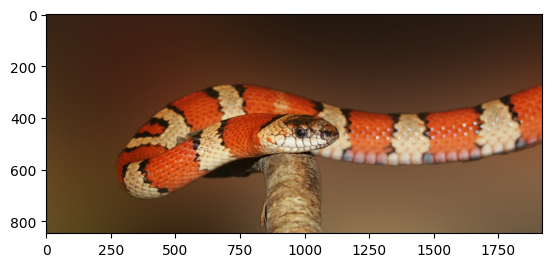

ResNet-50 v1.5 FP32 predictions with AIO enabled:
Latency = 55 ms
Top-1 prediction: [garter snake, grass snake]
Top-5 predictions: [ringneck snake, ring-necked snake, ring snake], [green snake, grass snake], [hognose snake, puff adder, sand viper], [boa constrictor, Constrictor constrictor], [garter snake, grass snake]

ResNet-50 v1.5 FP32 predictions with AIO disabled:
Latency = 74 ms
Top-1 prediction: [garter snake, grass snake]
Top-5 predictions: [ringneck snake, ring-necked snake, ring snake], [green snake, grass snake], [hognose snake, puff adder, sand viper], [boa constrictor, Constrictor constrictor], [garter snake, grass snake]



In [3]:
# visualizing output
# for the purpose of visualizing results let's load the image without pre-processing
img = cv2.imread(str(imagenet.path_to_latest_image))

# show the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print("ResNet-50 v1.5 FP32 predictions with AIO enabled:")
print("Latency = {:.0f} ms".format(latency_aio * 1000))
print("Top-1 prediction: {}".format(pp.get_imagenet_names(imagenet.extract_top1(output_aio[0])+1)))
print("Top-5 predictions: {}\n".format(pp.get_imagenet_names(imagenet.extract_top5(output_aio[0])+1)))

print("ResNet-50 v1.5 FP32 predictions with AIO disabled:")
print("Latency = {:.0f} ms".format(latency_non_aio * 1000))
print("Top-1 prediction: {}".format(pp.get_imagenet_names(imagenet.extract_top1(output_non_aio[0])+1)))
print("Top-5 predictions: {}\n".format(pp.get_imagenet_names(imagenet.extract_top5(output_non_aio[0])+1)))